#Todo
- Rajouter une section profiling
- Comparer les performances
- Comparer les résultats avec d'autres algos
- changer theta[init_pos]

In [3]:
# Parameters used by the notebook

%matplotlib inline

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'][:] = [5, 5]

# Line Segment Detector

Dans cette section, nous vous proposons d'appliquer ce que vous avez appris sur Python pour implémenter une version simplifiée du **Line Segment Detector** proposé par *R. Grompone von Gioi et al.* en 2012.  

Nous vous renvoyons vers la page IPOL du détecteur contenant une démo en ligne, le codes sources ainsi qu'un papier d'analyse des performances de ce détecteur :
http://www.ipol.im/pub/art/2012/gjmr-lsd/

## Fonctions utiles
Dans cette partie nous définissons plusieurs fonctions qui nous serons utiles pour le reste du TP.

In [4]:
def generate_synthetic_data(alpha=0.):
    """Generate a synthetic image to test the LSD detector.
    
    Parameters
    ----------
    alpha: float
        Noise intensity between [0. 1.]
    
    Returns
    ------
    im_out: array-like, shape (101, 101) 
        Floating image containing a white square in the middle corrupted by a random noise
    """
    im_out = alpha * np.random.rand(101, 111)
    im_out[24:76, 24:86] += 1. - alpha
    return im_out

In [5]:
def imshow(im):
    """Plot the image."""
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [6]:
def plt_gradient(vertical_gradient, horizontal_gradient):
    gradient = np.sqrt(vertical_gradient**2 + horizontal_gradient**2)
    theta = np.arctan2(vertical_gradient, horizontal_gradient)
    
    # Plot the gradient norm
    plt.figure(figsize=(10,10))
    ax = plt.subplot(121)
    ax.imshow(gradient, cmap='viridis')
    ax = plt.subplot(122)
    ax.imshow(theta, cmap='hsv')
    

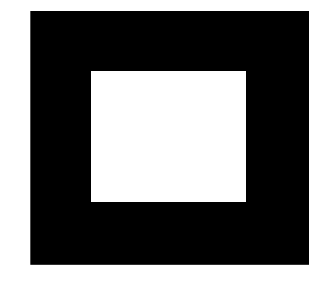

In [7]:
im = generate_synthetic_data()
imshow(im)

## Calcul du gradient de l'image

Pour détecter les contours, nous allons avoir besoin de calculer le vecteur gradient associé à chaque pixels de l'image. 

**Exercice :** Complétez la fonction suivante :

In [8]:
from scipy.ndimage import convolve

def compute_gradient(im):
    """Compute the gradient vector of an image.
    
    Parameters
    ----------
    
    im: array-like, shape (width, length)
    
    Returns
    -------
    vertical_gradient: array-like, shape (widht, length)
        Gradient values for the vertical direction.
    
    horizont_gradient: arrya-like, shape (widht, length)
        Gradient values for the horizontal direction.
    """
    # Kernel utiliser pour calculer le gradient de l'image
    vertical_edge_kernel = np.array([[-1, 1], [-1, 1]])
    horizontal_edge_kernel = np.array([[-1, -1], [1, 1]])
    
    # Exercice : Calculez vertical_gradient et horizontal_gradient
    vertical_gradient = convolve(im, horizontal_edge_kernel)
    horizontal_gradient = convolve(im, vertical_edge_kernel)
    
    return vertical_gradient, horizontal_gradient

**Exercice : **Pour être sur que `compute_gradient` se comporte correctement, tester la fonction pour différentes images.

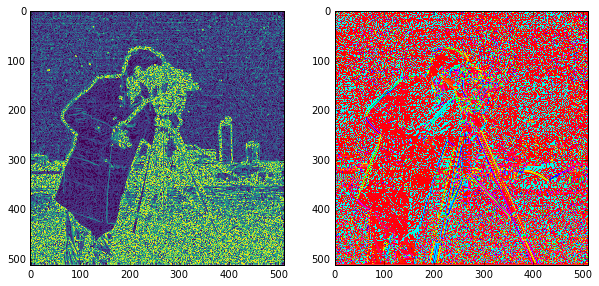

In [9]:
from skimage import data
from skimage.io import imread
# Tester la fonction compute_gradient pour différentes images et valeurs de sigma.

#im_orig = generate_synthetic_data() 
im_orig = data.camera()
#im_orig = imread('lsd-project/input/lsd_molecule.png') 

#grad_v, grad_h = compute_gradient()
plt_gradient(*compute_gradient(im_orig))


**Exercice : **Reporter les changements effectués précédement dans le fichier `filename` et ajoutez les tests unitaires correspondant au cas détecter précédement dans le fichier `test_filename`.

## Detection de lignes
Pour minimiser l'impact du bruit sur le calcul des gradient, nous allons filtré l'image avec un filtre gaussien de variance `sigma` 

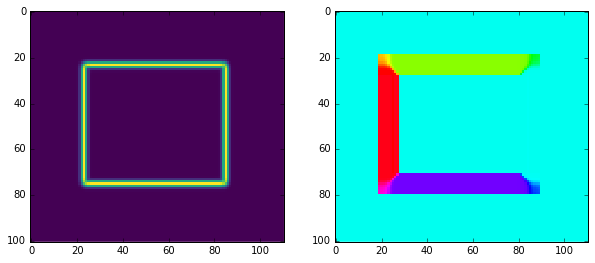

In [10]:
from skimage import filters

im_orig = generate_synthetic_data()
    
sigma = 1.
gradient = compute_gradient(filters.gaussian(im_orig, sigma=sigma))
plt_gradient(*gradient)

Une ligne dans LSD est défini comme un groupe de pixels voisins possèdant une orientation du gradient proche. Bien évidement un pixel ne peut appartenir qu'à une seule et unique ligne. 

**Exercice :** Implémenter la fonction `compute_line_group` qui groupe les pixels appartenant à une même ligne. 
- Nous utiliserons le tableau `checked` pour s'assurer que le pixel n'a pas déjà été utilisé.
- Nous supposerons que nous connaissons la position `init_pos` d'un pixel de la ligne pour initier la recherche. 
- Nous considèrerons comme potentiel candidats uniquement les pixels qui ont un valeur supérieure à `grad_min`.
(Voir l'article [IPOL](http://www.ipol.im/pub/art/2012/gjmr-lsd/) pour plus d'information sur le choix de `grad_min`).


In [11]:
def neighbors_in_line(pos, norm, theta, checked, tau, grad_min):
    """Define the neighbors positions which are in the same Line.
    
    Parameters
    ----------
    
    Returns
    -------
    
    """
    width, length =  norm.shape
    
    # Definie le voisinage
    p = np.meshgrid(range(max(0, pos[0]-1), min(width, pos[0]+2)),
                    range(max(0, pos[1]-1), min(length, pos[1]+2))) 
    
    # Calcule les ecarts d'angles
    theta_diff = theta[p] - theta[pos]
    theta_diff = np.min(np.array([theta_diff, -theta_diff]) % (2 * np.pi), axis=0) 
    
    # Compute the correct neighbors
    selected = np.logical_and(np.logical_not(checked[p]),
                              np.logical_and(norm[p] > grad_min, theta_diff < tau))
    return p[0][selected], p[1][selected]

In [12]:
def compute_line_group(init_pos, norm, theta, checked, tau, q=2.):
    """Compute the pixels
    
    Parameters
    ----------
    
    Returns
    -------
    
    """
    grad_min = q / 255. /np.sin(tau)
    
    pos_queue = [init_pos]
    checked[init_pos] = True

    for pos in pos_queue:
        p = neighbors_in_line(pos, norm, theta, checked, tau, grad_min)
        checked[p] = True
        pos_queue.extend((p[0][k], p[1][k]) for k in range(len(p[0])))

    return pos_queue        

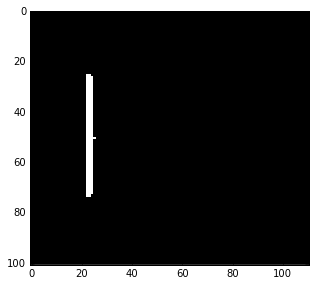

In [13]:
# Verification de la fonction 
init_pos = (50, 25)
#init_pos = (25, 50)
checked = np.zeros(im_orig.shape)
norm, theta = gradient[0] ** 2 + gradient[1] ** 2, np.arctan2(*gradient)

edge = compute_line_group(init_pos, norm, theta, checked, tau=.1)

plt.imshow(checked)
plt.show()

**Exercice :** Complétez les tests unitaires présent dans le fichier `test_.py` des fonctions précédentes.

## Groupe de lignes
Nous allons désormais calculer l'ensemble des lignes de l'images. Pour se faire le LSD propose de sélectionner les plus grandes valeurs de la norme du gradient comme point d'initialisation des lignes.

**Exercice :** Implémentez la fonction `compute_lines` qui détermine l'ensemble des groupes de lignes de l'image.

In [14]:
def compute_lines(gradient, tau, grad_max):
    # Calcul de la norme et de l'orientation du gradient
    norm = gradient[0] ** 2 + gradient[1] ** 2
    theta = theta = np.arctan2(*gradient) % (2 * np.pi)
    
    # Calcul des pixels de norme de gradient élevées
    _, length = norm.shape
    pos = np.argsort(norm, axis=None)
    pos = [(p //length, p % length) for p in pos[:-(norm >= grad_max).sum()-1:-1]]
    
    lines = []
    checked = np.zeros(norm.shape)
    for p in pos:
        if checked[p]:
            continue
        lines.append(compute_line_group(p, norm, theta, checked, tau))
            
    return lines

Number of line: 472


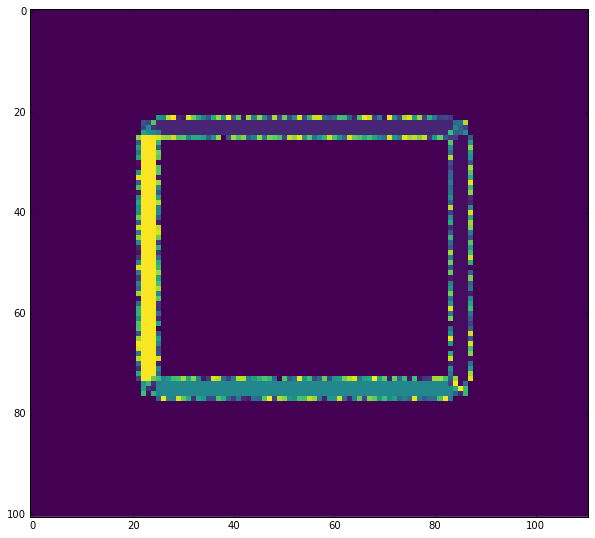

In [16]:
# show the edges groups
tau, grad_max = .1, .01

_, width = im_orig.shape
res = np.zeros((im_orig.shape))

lines = compute_lines(gradient, tau=tau, grad_max=grad_max)
print('Number of line: %d' %len(lines))
for k, line in enumerate(lines):
    pos = [l[0]* width + l[1] for l in line]
    res.ravel()[pos] = np.random.rand()#k+10

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='viridis')
plt.show()

## Calculs des paramètre de lignes

Finir d'écrire blabla.

In [17]:
from scipy import linalg 

def compute_lines_parameters(lines, norm):
    centers = np.empty((len(lines), 2))
    alphas = np.empty((len(lines), 1))
    sizes = np.empty((len(lines), 2))
    
    for k, line in enumerate(lines):
        # Convertion des position en numpy
        pos = np.array([[x, y] for x,y in line])
        grad_norm = norm[pos[:, 0], pos[:, 1]]
        
        centers[k] = np.round(np.sum(pos * grad_norm[:, np.newaxis], axis=0) / sum(grad_norm))
        
        pos = pos - centers[k]
        _, v = linalg.eigh(np.dot(pos.T, pos) / sum(grad_norm))
        alphas[k] = np.arctan2(v[1, 0], -v[1, 1])

        sizes[k] = 2 * np.abs(np.dot(pos, v)).max(axis = 0)
    
    return centers, alphas, sizes

In [18]:
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

def draw_rectangle(ax, center, angle, length, width):
    rect = patches.Rectangle((-length // 2, -width // 2), length, width, ec=np.random.rand(3,1), lw=3, fill=False)
    rect.set_transform(Affine2D().rotate(np.pi/2 - angle) + 
                       Affine2D().translate(center[1], center[0]) + 
                       ax.transData)
    ax.add_patch(rect) 
    
def plot_rectangles(im, centers, alphas, sizes):
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    ax.imshow(im)
    ax.scatter(centers[:,1], centers[:,0])
    for center, alpha, size in zip(centers, alphas, sizes):
        draw_rectangle(ax, center, alpha, *size)
    plt.show()  
    
def plot_lines(im, centers, alphas, sizes):
    plt.figure(figsize=(20,20))
    ax = plt.subplot()  
    ax.imshow(im)
    for center, alpha, size in zip(centers, alphas, sizes):
        ax.plot([center[1] - np.floor(.5 * size[1]*np.cos(alpha)), 
                 center[1] + np.floor(.5 * size[1]*np.cos(alpha))],
                [(center[0] + np.floor(.5 * size[1]*np.sin(alpha))), 
                 (center[0] - np.floor(.5 * size[1]*np.sin(alpha)))], 'b', lw=3)
    ax.axis('equal')
    plt.show()    

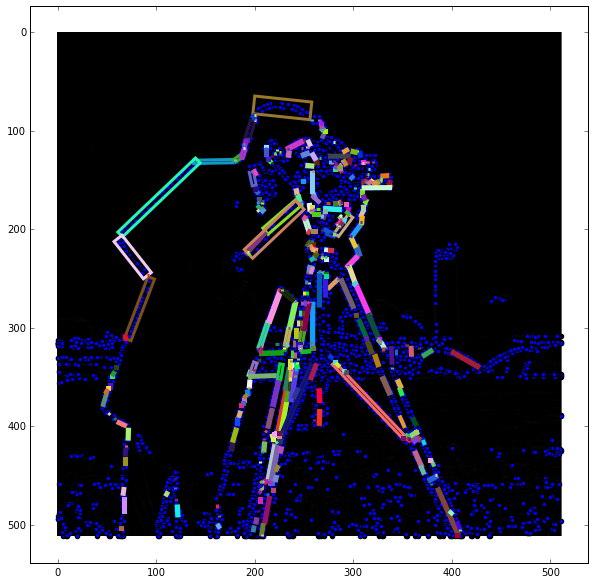

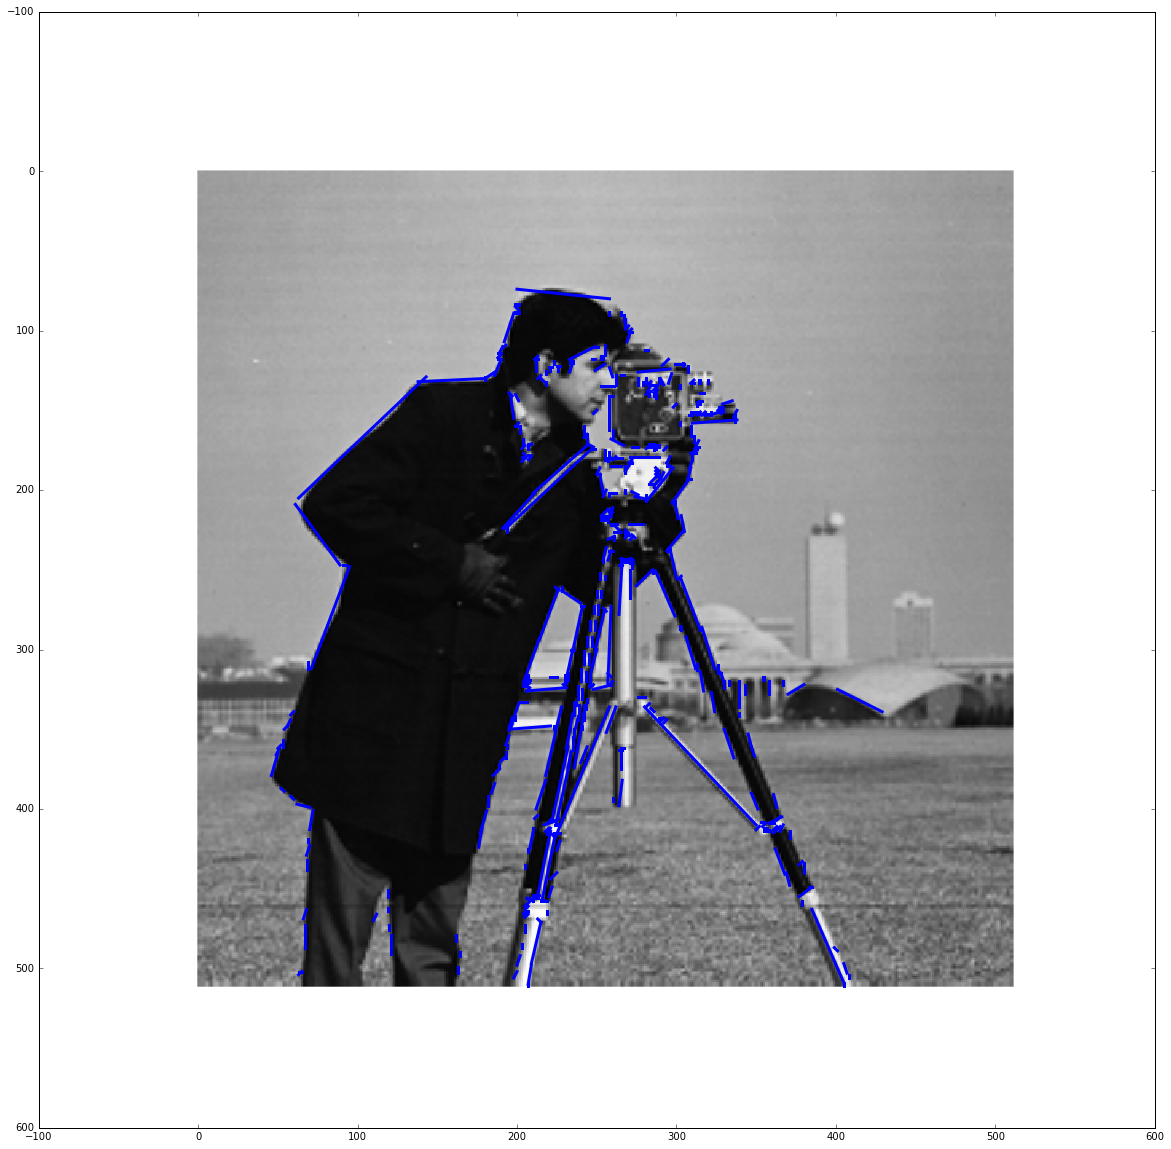

In [28]:
lines = compute_lines(gradient, tau=tau, grad_max=grad_max)
params = compute_lines_parameters(lines, norm)
plot_rectangles(norm, *params)
plot_lines(im_orig, *params)

## Critère de bruit

In [20]:
from scipy.special import gammaln
from scipy.misc import logsumexp

def nfa(im_numel, k, n, tau):
    p = tau / np.pi
    proba_sum = (gammaln(n+1) - gammaln(np.arange(k + 1, n + 2)) - gammaln(np.arange(n - k + 1, 0, -1)) +
                 np.log(p) * np.arange(k, n + 1) + np.log(1-p) * np.arange(n - k, -1, -1)).sum()
    return np.exp(2.5 * np.log(im_numel) + logsumexp(proba_sum))

def select_lines_nfa(lines, centers, alphas, sizes, tau):
    nfa_score = np.empty(len(lines))
    for k, (line, size) in enumerate(zip(lines, sizes)):
        nfa_score[k] = nfa(im.size, len(line), 4*size.prod(), tau / np.pi)
        
    return centers[nfa_score < 1, :], alphas[nfa_score < 1, :], sizes[nfa_score < 1]

# Resultats

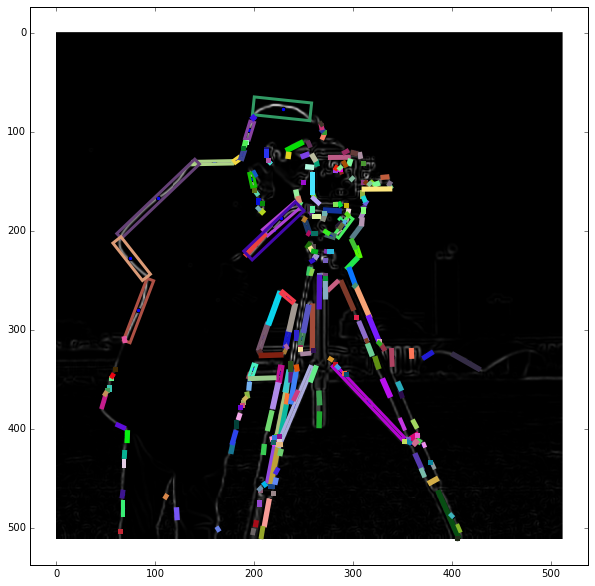

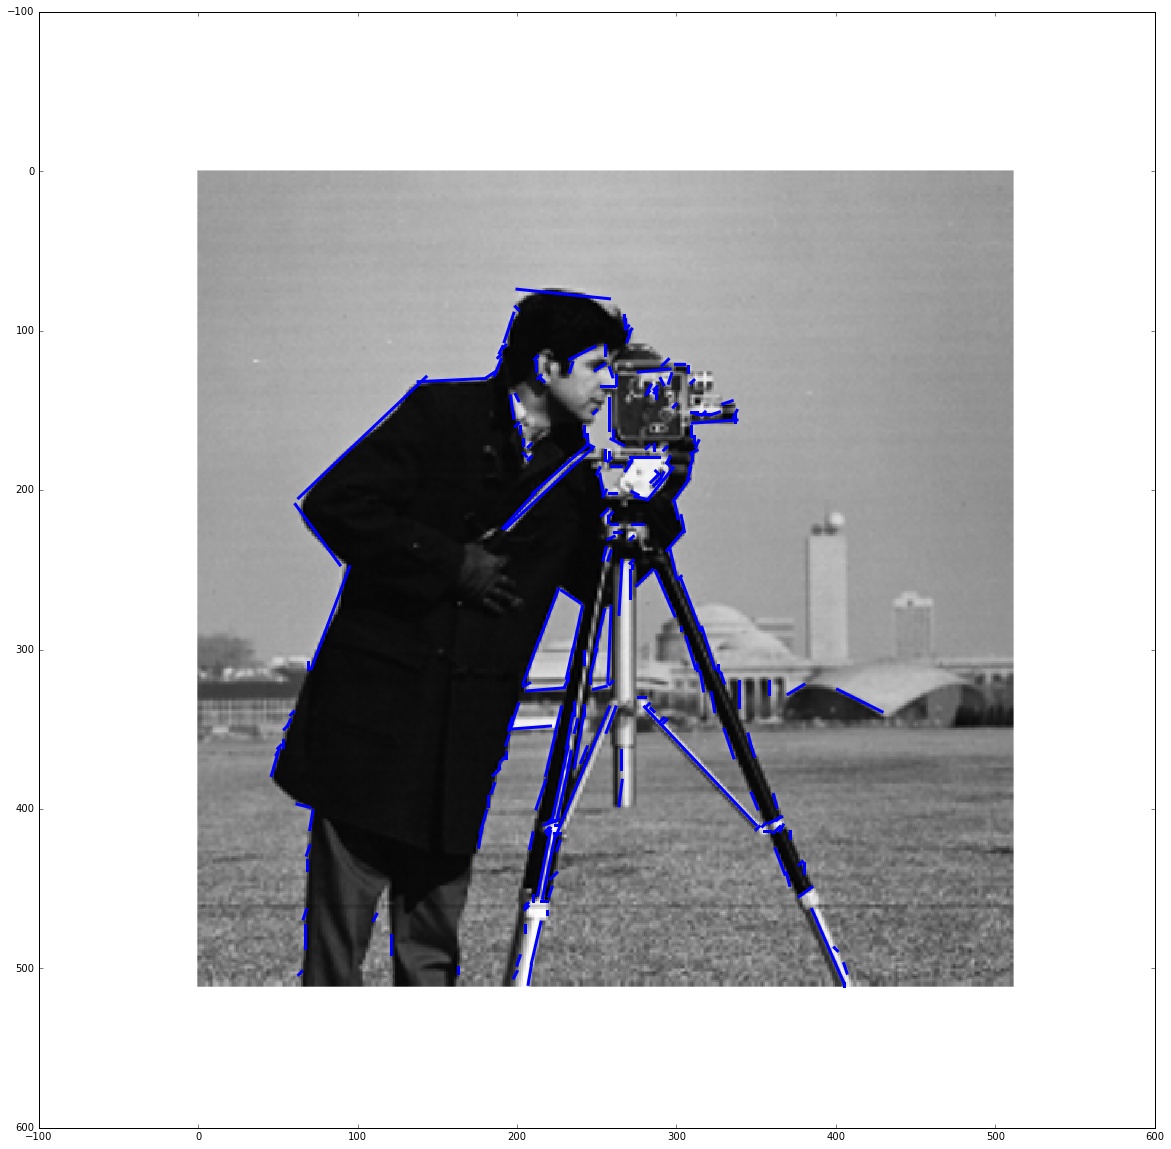

In [27]:
from skimage import data
from skimage import img_as_float

im_orig = img_as_float(data.camera())
    
tau, grad_max, sigma = .1, .01, 1.
gradient = compute_gradient(filters.gaussian(im_orig, sigma=sigma))

norm = gradient[0] ** 2 + gradient[1] ** 2
theta = theta = np.arctan2(*gradient) % (2 * np.pi)

lines = compute_lines(gradient, tau=tau, grad_max=grad_max)
params = compute_lines_parameters(lines, norm)
params = select_lines_nfa(lines, *params, tau=tau)

plot_rectangles(norm, *params)
plot_lines(im_orig, *params)

In [195]:
0.6/np.pi


0.1909859317102744